# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

### Problem statement / aim for this project

In [84]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy
import csv
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
%matplotlib inline
from sklearn.decomposition import PCA 
import pandas as pd
from pandas.io import sql
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
import colorlover as cl
from IPython.display import HTML
py.sign_in('ajbentley', 'zjfu2vasav')

#### Step 2: Load data to dataframe 

In [85]:
cancel = pd.read_csv("../../projects-weekly/project-07/assets/airport_cancellations.csv")

ops = pd.read_csv("../../projects-weekly/project-07/assets/Airport_operations.csv")

ap = pd.read_csv("../../projects-weekly/project-07/assets/airports.csv")

cancel.rename(columns ={'Airport':'AP_NAME'}, inplace=True)

df = cancel.join(ap, rsuffix='ap')
df.pop('AP_NAMEap');

df = df.join(ops, rsuffix='ops')


#### Enhance / refine data

As the project focus is on current problems, including inability to course-correct (airports which are flat or worsening in delays) I'm going to:

1. merge the three available databases, eliminate anything that does not apply to delay measurements
2. create change metrics. while a more robust score could be determine, I'm using the change from 5 years prior.
3. eliminating all but the current year (2014)

In [86]:
# create df that only refs airport name, year, and delay and arrival information (continuous, not categorical data)


dfn = ['AP_NAME', 'Year', 'Departure Cancellations','Arrival Cancellations','Departure Diversions','Arrival Diversions',\
       'departures for metric computation','arrivals for metric computation',\
       'percent on-time gate departures', 'percent on-time airport departures','percent on-time gate arrivals',\
       'average_taxi_out_time','average taxi out delay','average airport departure delay','average airborne delay',\
       'average taxi in delay','average block delay','average gate arrival delay' ]
dfn = pd.DataFrame(df[dfn])

dfn.columns = ['ap_name', 'year','D_cancel', 'A_cancel','D_divert','A_divert','D_4met','A_4met', '%on/t_gate_D',\
               '%on/t_ap_D', '%on/t_gate_A', 'avg_taxi_out_time', 'avg_taxi_out_del', 'avg_ap_D_del',\
               'avg_airborne_del', 'avg_taxi_in_del', 'avg_block_del','avg_gate_A_del']

# le = LabelEncoder()
# le.fit(dfn.ap_name)
# leapn = pd.DataFrame(le.transform(dfn.ap_name))

# dfn = pd.concat([leapn,dfn], axis = 1)

# dfn.pop('ap_name')
# dfn.rename(columns={0:'ap_name'}, inplace=True)

dfn.head(15)

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del,avg_gate_A_del
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.41,2.41,12.32,1.82,1.03,2.79,11.48
5,ABQ,2009.0,192.0,162.0,74.0,26.0,42550,42704,0.8341,0.8147,0.8224,9.88,1.89,10.45,1.74,0.92,1.98,9.27
6,ABQ,2010.0,222.0,177.0,71.0,50.0,42302,42169,0.8144,0.7907,0.8047,9.95,2.05,11.58,1.66,0.95,1.90,10.23
7,ABQ,2011.0,345.0,294.0,77.0,61.0,42283,42297,0.8072,0.7758,0.8022,10.50,2.51,12.57,1.58,0.84,1.87,10.63
8,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,0.8177,10.27,2.32,12.11,1.41,0.98,1.80,9.73
9,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,0.7554,10.77,2.64,14.28,1.60,0.92,2.35,12.76


In [87]:

# dfn.to_csv('/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
# assets/dfn.csv')

In [88]:
# Adding change columns for all 

dfn['Chg_D_cancel'] = dfn['D_cancel'].pct_change(5)
dfn['Chg_A_cancel'] = dfn['A_cancel'].pct_change(5)
dfn['Chg_D_divert'] = dfn['D_divert'].pct_change(5)
dfn['Chg_A_divert'] = dfn['A_divert'].pct_change(5)
dfn['Chg_D_4met'] = dfn['D_4met'].pct_change(5)
dfn['Chg_A_4met'] = dfn['A_4met'].pct_change(5)
dfn['Chg_%on/t_gate_D'] = dfn['%on/t_gate_D'].pct_change(5)
dfn['Chg_%on/t_ap_D'] = dfn['%on/t_ap_D'].pct_change(5)
dfn['Chg_%on/t_gate_A'] = dfn['%on/t_gate_A'].pct_change(5)
dfn['Chg_avg_taxi_out_time'] = dfn['avg_taxi_out_time'].pct_change(5)
dfn['Chg_avg_taxi_out_del'] = dfn['avg_taxi_out_del'].pct_change(5)
dfn['Chg_avg_ap_D_del'] = dfn['avg_ap_D_del'].pct_change(5)
dfn['Chg_avg_airborne_del'] = dfn['avg_airborne_del'].pct_change(5)
dfn['Chg_avg_taxi_in_del'] = dfn['avg_taxi_in_del'].pct_change(5)
dfn['Chg_avg_block_del'] = dfn['avg_block_del'].pct_change(5)
dfn['Chg_avg_gate_A_del'] = dfn['avg_gate_A_del'].pct_change(5)

dfn.head()

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# making new db with only 2014 data. As indicated at the head of this document, my preferred analysis on this would\
# to just use 2014 and the change metrics. I think prior years' data are useful mostly for the change.

df14 = pd.DataFrame(dfn.loc[df['Year'] == 2014])

df14.replace([np.inf, -np.inf], np.nan, inplace=True)
df14.dropna(inplace=True)
df14.drop(['year'], axis=1, inplace=True)

df14.head()

,ap_name,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
10,ABQ,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,0.7320,...,-0.106702,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918
21,ANC,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,0.8600,...,0.021696,0.015342,0.040658,-0.092874,-0.141935,-0.222922,0.062338,0.741935,0.090692,-0.321630
32,ATL,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,0.8123,...,0.015949,0.209153,0.107430,-0.203297,-0.494347,-0.258380,-0.172205,-0.416842,-0.436842,-0.249093
43,AUS,484.0,435.0,88.0,97.0,60588,60264,0.7627,0.7382,0.7222,...,-0.064631,-0.070628,-0.064508,0.007712,0.004878,0.274734,-0.004425,-0.068966,0.070632,0.272584
54,BDL,467.0,421.0,57.0,32.0,39279,39109,0.7953,0.7605,0.7569,...,-0.047431,-0.042674,-0.045884,-0.019969,-0.107266,0.167072,-0.212121,0.104651,-0.098976,0.264103




# SQL work here




#### 1.2 What are the risks and assumptions of our data? 

While there is considerable information presented there is a massive amount of information that feels like it most be colinear (several flavors of delays and arrivals, all of which probably correlate highly). It would be useful to see if there is a way to combine.

There's also data that are missing. It would be significant to see meteorological data, which I have to imagine the FAA collects, to show whether temperature and precipitation have seen significant shifts in this time.

It could be useful to see whether there is any difference in monthly numbers. Has tourism increased?

Once we get down to the individual airports that we need to consider it would be good to see whether there have been changes in the airlines serving the airport or in the sources / destinations of the planes. If flights from Denver tend to be late and they've just started a new direct flight from Denver to DC then the delays in DC would change.

There is a mixture of measurement scales--total counts, coordinates, percentages, and minutes. Data will definitely need standardization to be usable.

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 33 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
Key                                   805 non-null float64
LocID                                 804 non-null object
ALIAS                                 631 non-null object
Facility Type                         805 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP Type                               805 non-null object
Latitude           

#### Creating new dataframe without change metrics for visualizations

In [91]:
nclist = df14.columns[1:16]
nclist

Index([u'D_cancel', u'A_cancel', u'D_divert', u'A_divert', u'D_4met',
       u'A_4met', u'%on/t_gate_D', u'%on/t_ap_D', u'%on/t_gate_A',
       u'avg_taxi_out_time', u'avg_taxi_out_del', u'avg_ap_D_del',
       u'avg_airborne_del', u'avg_taxi_in_del', u'avg_block_del'],
      dtype='object')

In [92]:
df14nc = pd.DataFrame(df14[nclist])
# df14nc.drop(df14nc('Chg_D_cancel'), axis=1, inplace=True)
df14nc.head()

,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del
10,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,0.7320,10.64,2.41,15.99,1.73,1.02,2.40
21,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,0.8600,11.33,1.33,12.34,4.09,0.54,4.57
32,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,0.8123,17.40,4.92,15.93,2.74,2.77,3.21
43,484.0,435.0,88.0,97.0,60588,60264,0.7627,0.7382,0.7222,11.76,2.06,15.59,2.25,1.08,2.88
54,467.0,421.0,57.0,32.0,39279,39109,0.7953,0.7605,0.7569,12.76,2.58,14.39,2.34,0.95,2.64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117efded0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13bc13690>]], dtype=object)

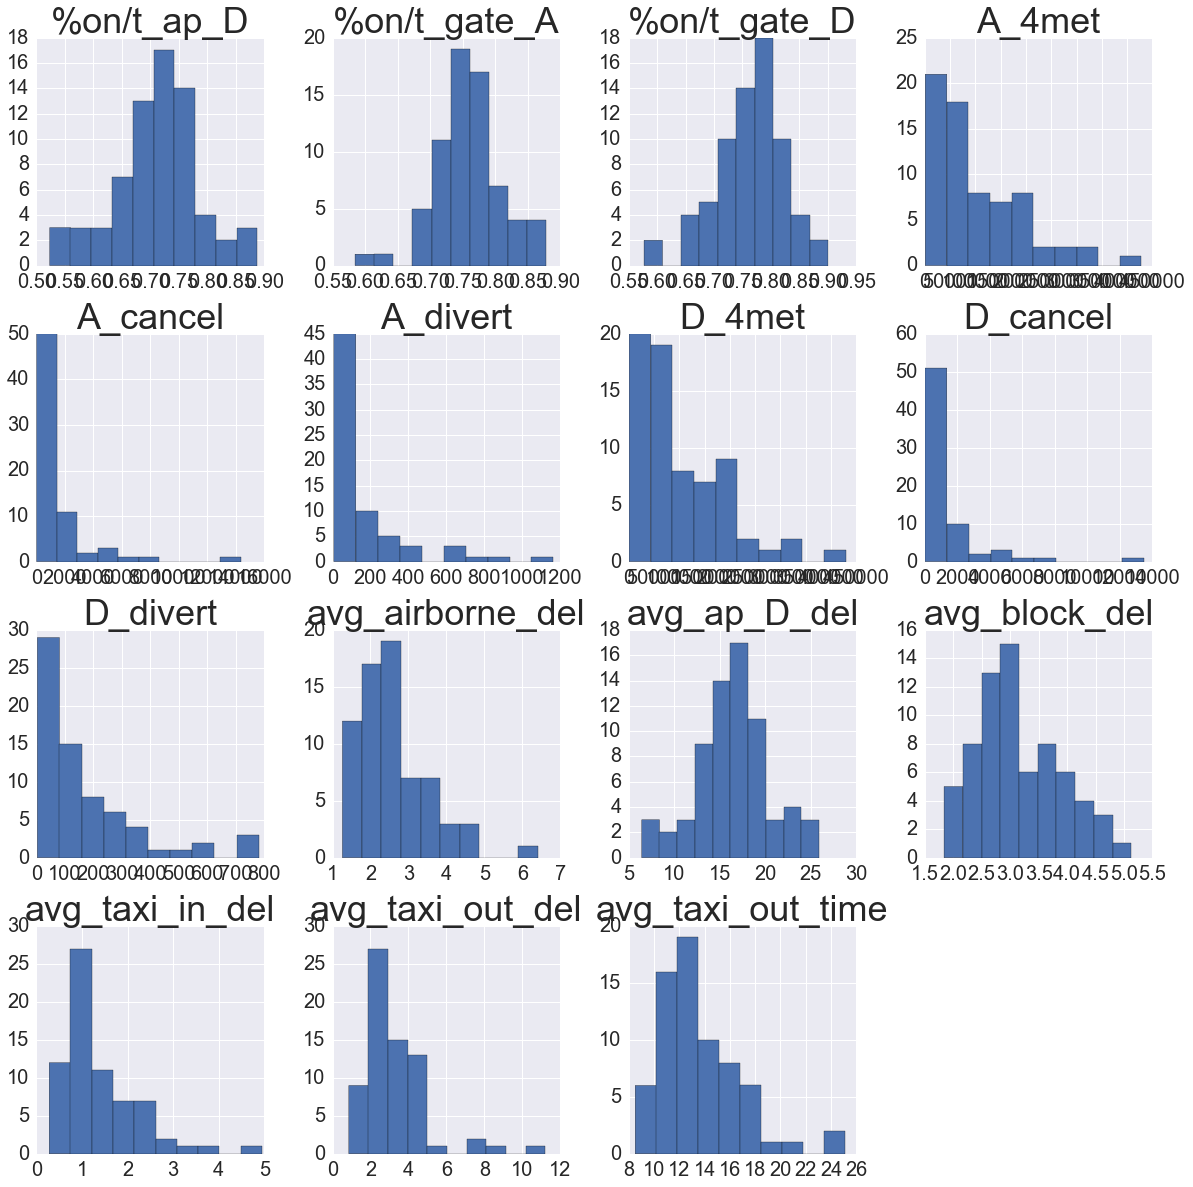

In [93]:
df14nc.hist(figsize=(20,20))

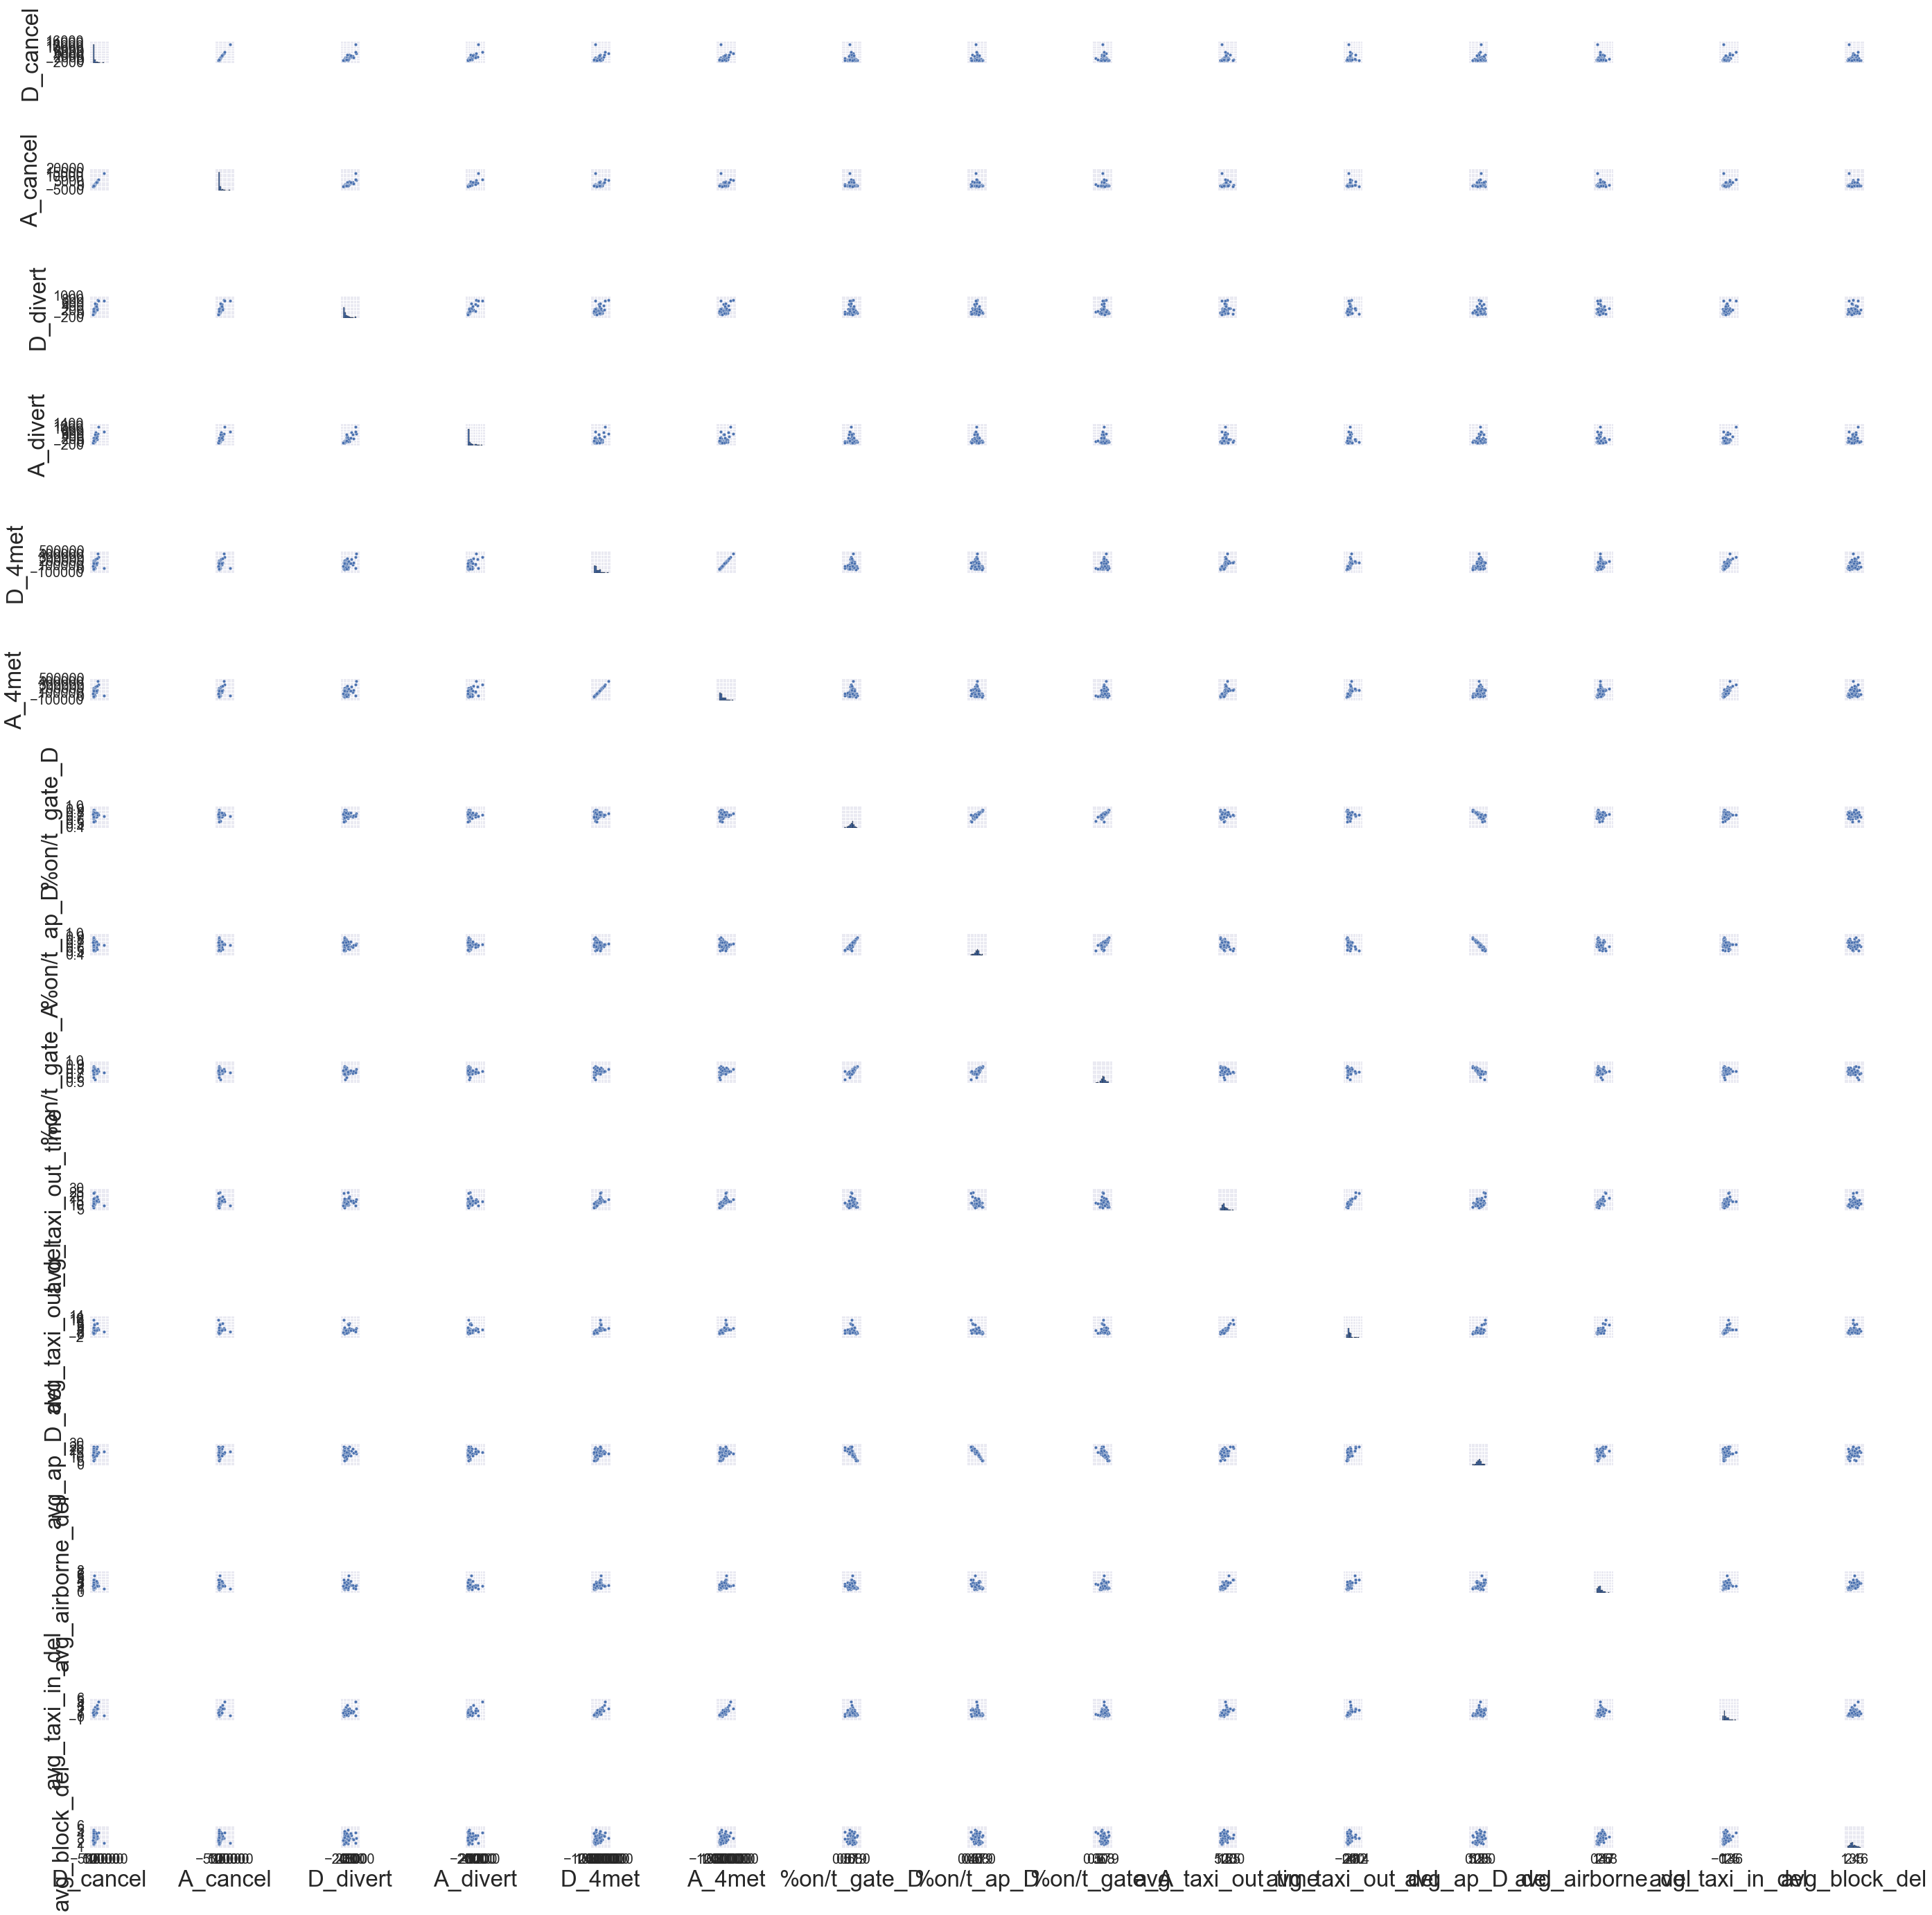

In [94]:
# if you want the eyetest that's the pairplot here, knock yourself out

#sns.pairplot(df14nc, kind="scatter")

In [95]:
df14nc.describe()

,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,1412.521739,1457.231884,174.579710,166.217391,102707.217391,102361.159420,0.760845,0.711397,0.759041,13.606522,3.283478,16.554928,2.622609,1.386087,3.150870
std,2030.302199,2184.822904,181.351009,221.172868,88841.995332,88749.797704,0.060968,0.073705,0.051796,3.302270,1.776569,4.049689,0.941164,0.834460,0.737501
min,17.000000,11.000000,3.000000,7.000000,955.000000,948.000000,0.577100,0.523300,0.584600,8.520000,0.860000,6.440000,1.260000,0.280000,1.840000
25%,429.000000,391.000000,57.000000,34.000000,35084.000000,35010.000000,0.723800,0.679900,0.728300,11.260000,2.150000,14.390000,1.960000,0.850000,2.630000
50%,654.000000,680.000000,88.000000,83.000000,67435.000000,66704.000000,0.768100,0.717200,0.756900,12.790000,2.710000,16.460000,2.430000,1.170000,3.050000
75%,1393.000000,1535.000000,213.000000,175.000000,166460.000000,164346.000000,0.795300,0.751800,0.783100,15.440000,3.970000,18.980000,3.090000,1.740000,3.750000
max,13454.000000,14355.000000,781.000000,1164.000000,428954.000000,428312.000000,0.900700,0.888100,0.878400,25.100000,11.210000,25.920000,6.410000,4.950000,5.130000


#### Do the data have normal distribution?

The histograms make it clear that they do not. Most of these measurements are right skewed, often heavily so. 

The mean and median reflected in the describe output confirm that these are not normally distributed.

#### Find correlations between the data

In [96]:
df_corr = abs(df14nc.corr())
# df_corrdf = pd.DataFrame(df_corr)
# df_corrdf

df_corr = df_corr.applymap(lambda x: x if x >= 0.9 else '')
df_corr

,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del
D_cancel,1,0.998873,,,,,,,,,,,,,
A_cancel,0.998873,1,,,,,,,,,,,,,
D_divert,,,1,,,,,,,,,,,,
A_divert,,,,1,,,,,,,,,,,
D_4met,,,,,1,0.999935,,,,,,,,,
A_4met,,,,,0.999935,1,,,,,,,,,
%on/t_gate_D,,,,,,,1,,,,,,,,
%on/t_ap_D,,,,,,,,1,,,,0.948584,,,
%on/t_gate_A,,,,,,,,,1,,,,,,
avg_taxi_out_time,,,,,,,,,,1,,,,,


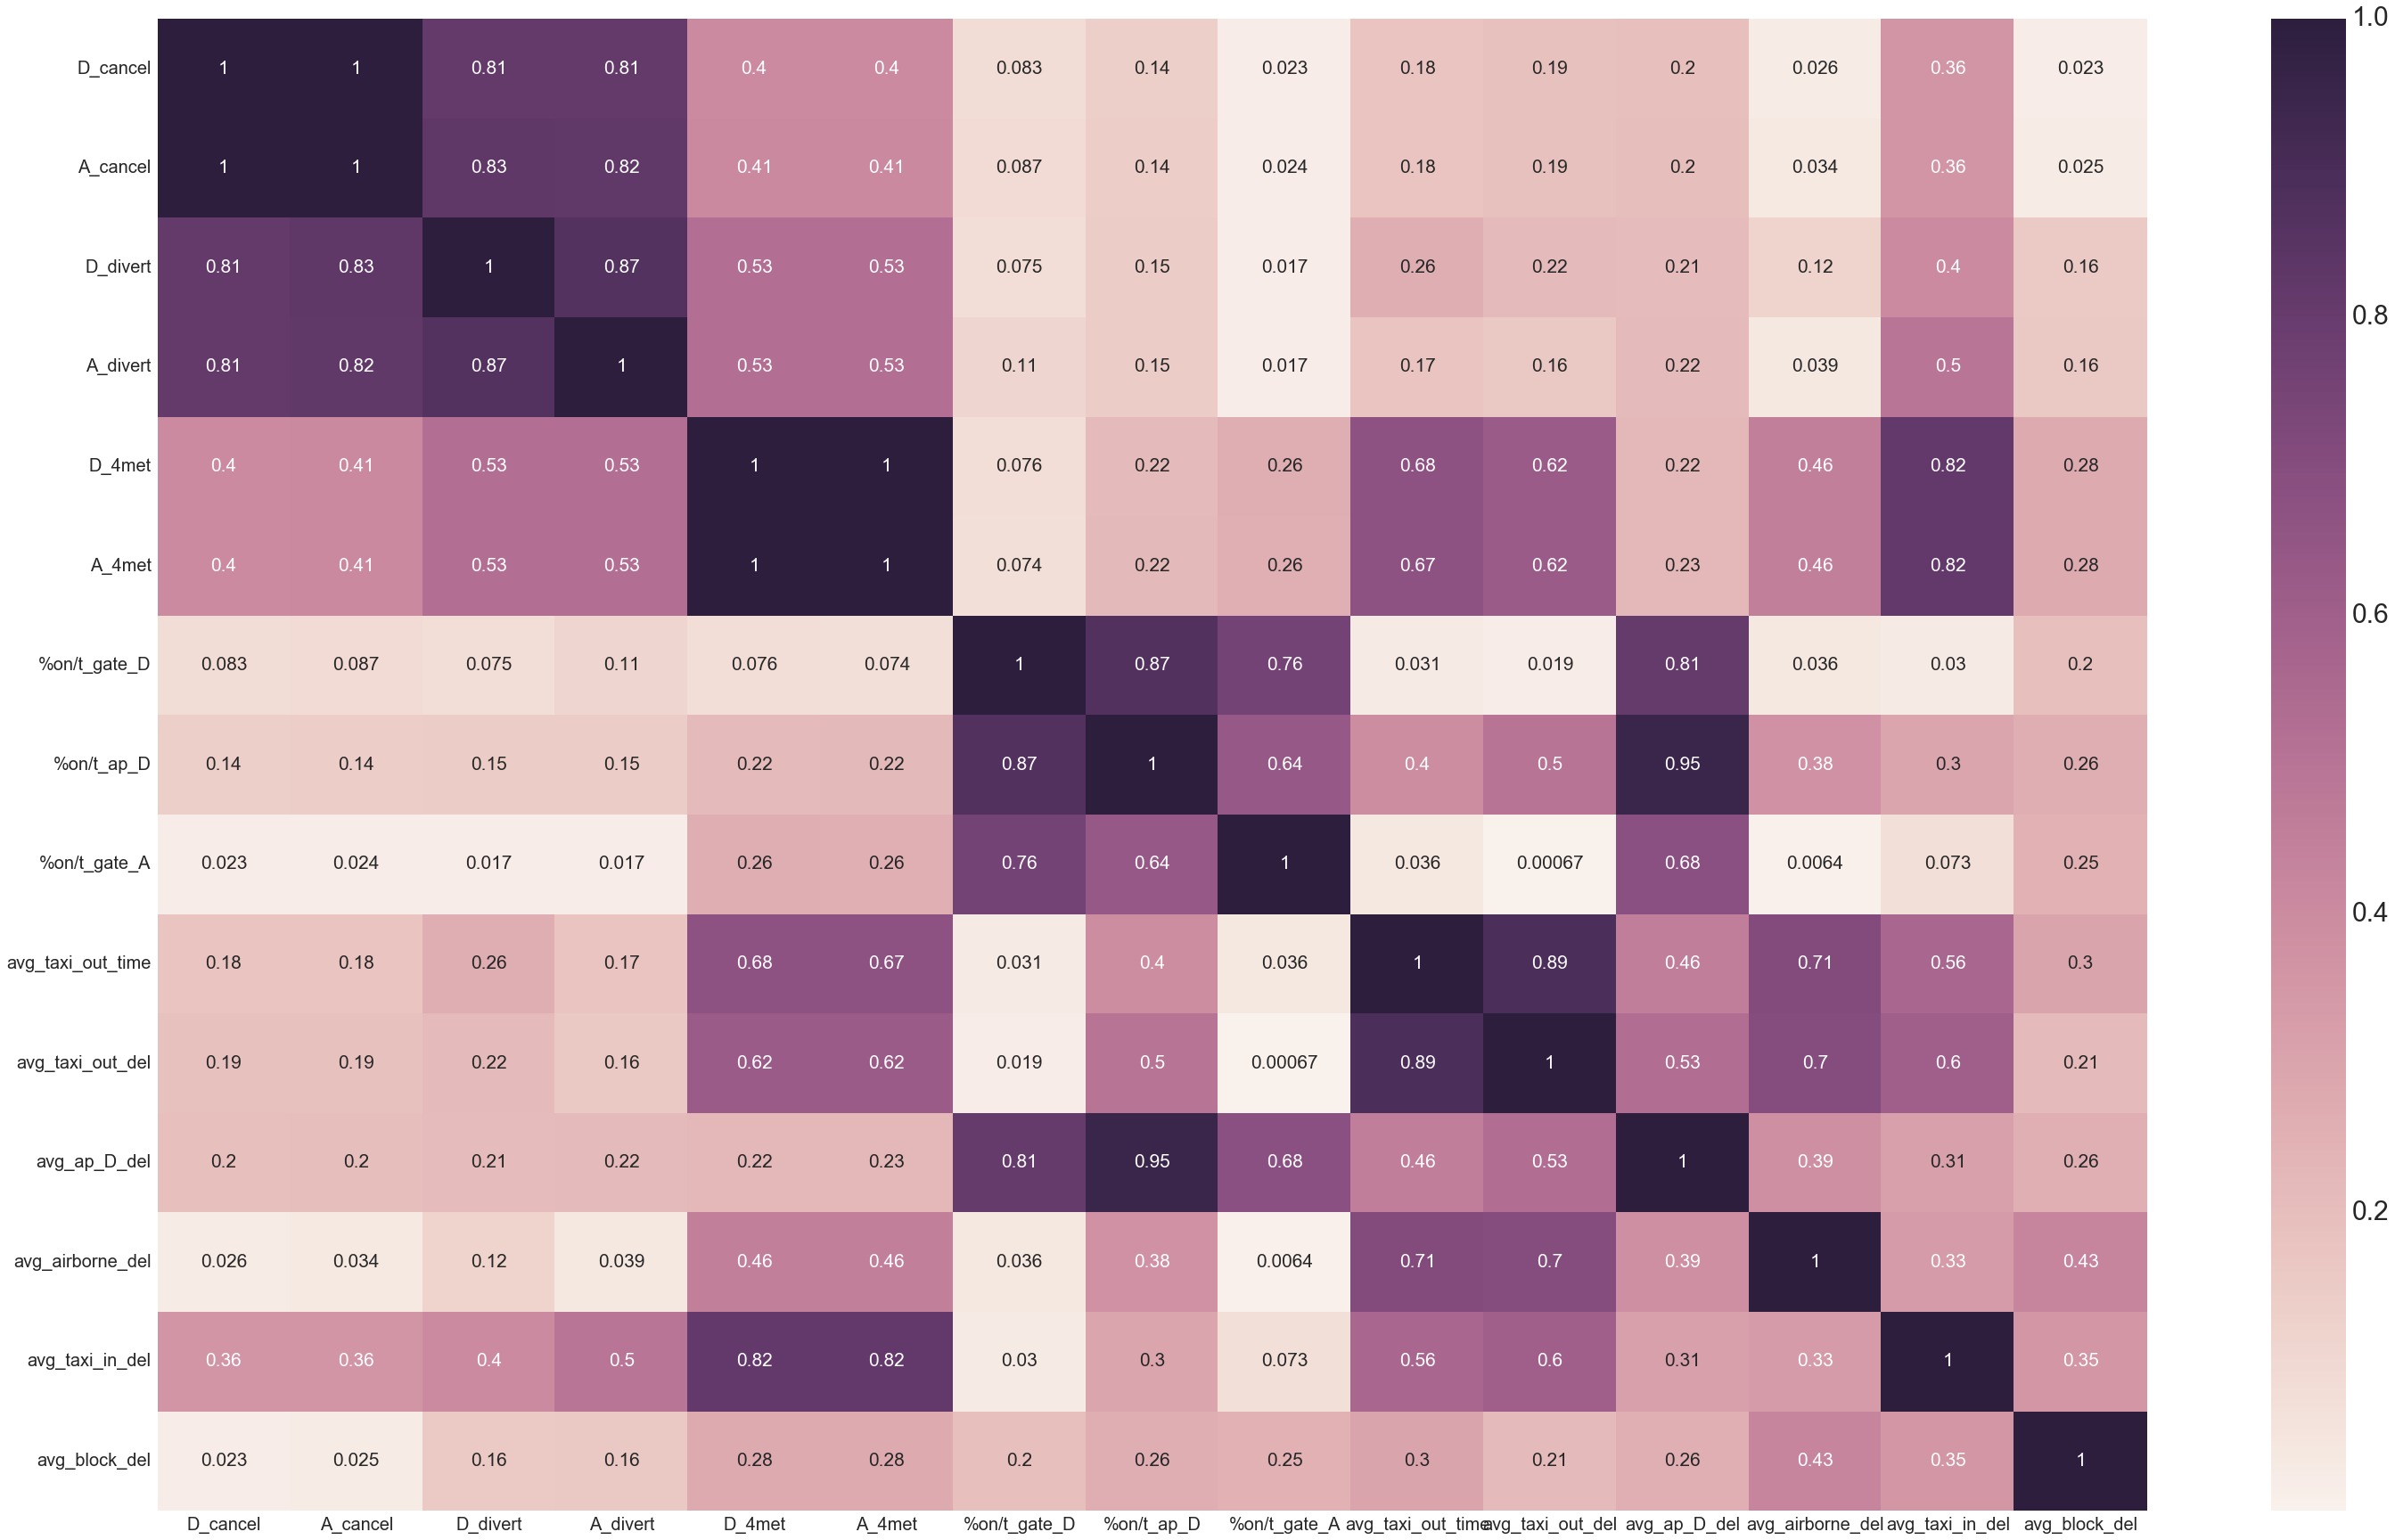

In [97]:
df_corr = abs(df14nc.corr())
# dfncr = pd.DataFrame(df_corr)

df_corr.replace([np.inf, -np.inf], np.nan, inplace=True)
df_corr.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(50,30))   
sns.set(font_scale=3)
ax = sns.heatmap(df_corr, annot=True, annot_kws={"size": 21})

#### 4.3 What is the value of understanding correlations before PCA?

My original thought had been that you would want to check for colinearity between features before pouring them into PCs but the more I think of it the less sense that makes. Shouldn't the PCA process effectively downgrade extraneous information?

In previous incarnations of this project I did considerable work with removing features to improve PCA but found the practice had little impact. Below is a description of one such analysis:

 Checking for pairs with correlations >.95. Will exclude the one of the pair with the greater sum of absolute correlations for all features (the one that has more of its explanatory power already covered by other features). If there is a tie (or close to) I'll favor delays over arrivals.

* A - Departure Cancellations and Arrival Cancellations .999 correlated, dropping Arrival Cancellations
* B - Deparetures for Metric Computations and Arrivals for Metric Computations .999 correlated, dropping Arrivals
* C - Average Airport Departure Delay and Percent on-time airport departures -.96 correlated, dropping Average Airport Departure Delay
* D - Average Gate Arrival Delay and Percent on-time gate arrivals -.95 correlated, dropping Percent on-time Gate Arrivals.

 Had first done this naive--none of the above exclusions.

 After doing this my cumed eigenvalues declined. Testing to see whether I should have done different exclusions if any.

* Naive 
* i. ABCD excluded 
* ii. ABC excluded 
* iii. ABD excluded 
* iv. ACD excluded 
* v. BCD excluded 
* vi. inverse ABCD (excluded the other partner in the pair) 
* vii. iABC excluded 
* viii. iABD excluded 
* ix. iACD excluded 
* x. iBCD excluded


 Data: Cum PC1 / PC2 / PC3
* 36 / 66 / 82 
* i. 37 / 62 / 79 
* ii. 34 / 64 / 80 
* iii. 37 / 64 / 80 
* iv. 40 / 64 / 80 
* v. 38 / 62 / 80 
* vi. 37 / 62 / 80 
* vii. 35 / 64 / 81 
* viii. 36 / 65 / 81 
* ix. 41 / 64 / 80 
* x. 38 / 62 / 81

 From this analysis I can see that dropping factors based on correlation is actually harmful and that I had been targeting the wrong member of the correlated pairs.

 As a last test I'll look at dropping only one of the inverse members at a time:
* dropping iA: 36 / 67 / 81 
* dropping iB: 35 / 65 / 82 
* dropping iC: 38 / 64 / 81 
* dropping iD: 38 / 65 / 81

  So it looks like excluding for correlation is the wrong way to go.

### Part 5: Perform a PCA

In [98]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 10 to 793
Data columns (total 33 columns):
ap_name                  69 non-null object
D_cancel                 69 non-null float64
A_cancel                 69 non-null float64
D_divert                 69 non-null float64
A_divert                 69 non-null float64
D_4met                   69 non-null int64
A_4met                   69 non-null int64
%on/t_gate_D             69 non-null float64
%on/t_ap_D               69 non-null float64
%on/t_gate_A             69 non-null float64
avg_taxi_out_time        69 non-null float64
avg_taxi_out_del         69 non-null float64
avg_ap_D_del             69 non-null float64
avg_airborne_del         69 non-null float64
avg_taxi_in_del          69 non-null float64
avg_block_del            69 non-null float64
avg_gate_A_del           69 non-null float64
Chg_D_cancel             69 non-null float64
Chg_A_cancel             69 non-null float64
Chg_D_divert             69 non-null float64


In [99]:
x2 = df14.ix[:,1:33].values
y2 = df14.ix[:,0].values

xStand = pd.DataFrame(StandardScaler().fit_transform(x2), columns=df14.columns[1:33])
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)



In [100]:
pca2 = PCA(n_components=2)
X = pca2.fit_transform(xStand)

In [101]:
covMat = np.cov(X.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0]);

7.04907196122
6.54243768978


In [102]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)

[  51.86378954  100.        ]


In [103]:
PCAdf2 = pd.DataFrame(X, columns=['PC1','PC2'])
j = PCAdf2.PC1
k = PCAdf2.PC2

PCAdf2.head()

,PC1,PC2
0,3.630733,-0.645313
1,-2.550770,-3.053331
2,-6.844147,2.887877
3,1.683843,-0.631700
4,0.879509,-1.814200


In [104]:
# Let's see how closely related each PC is to the original features

PCPieces = abs(pd.DataFrame(pca2.components_, columns = df14.columns[1:33], index = ['PC1', 'PC2']))
PCPieces.T.sort_values('PC1', ascending = False).head(30)

,PC1,PC2
Chg_%on/t_gate_A,0.330749,0.086751
Chg_%on/t_ap_D,0.311219,0.093743
Chg_avg_ap_D_del,0.304368,0.119327
Chg_avg_gate_A_del,0.302912,0.109161
Chg_%on/t_gate_D,0.297262,0.101353
%on/t_gate_D,0.239036,0.205675
%on/t_gate_A,0.232829,0.170504
D_4met,0.222301,0.238506
A_4met,0.221371,0.238927
Chg_avg_block_del,0.195719,0.089274


Interesting to see that the change metrics were so strong.

Also interesting, regarding the correlations, some highly correlated pairs saw neither measurement supplying much impact. 

In [105]:
eigen_pairs = [[eigenValues[i], eigenVectors[:,i]] for i in range(len(eigenValues))]
eigen_pairs.sort(reverse=True)

weight_2d_projection = np.hstack((eigen_pairs[0][1].reshape(eigenVectors.shape[1],1),
                                  eigen_pairs[1][1].reshape(eigenVectors.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection;


Weight data 2d PCA projection matrix:
[[  1.00000000e+00   1.27498243e-14]
 [ -1.27498243e-14   1.00000000e+00]]


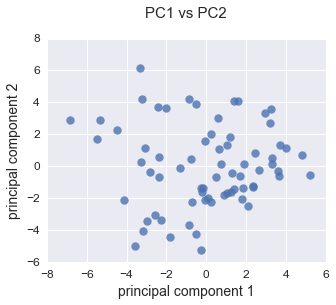

In [106]:
fig = plt.figure(figsize=(5,4))

ax = fig.gca()
ax = sns.regplot(j,k,
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=14)
ax.set_ylabel('principal component 2', fontsize=14)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=15
            )

plt.show()

No strong clusters apparent

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

Step 1 was to get PCs so now we're ready for step 2, clustering. I'll use DB-SCAN since there's not a lot of data and I haven't found any strong visible clusters

In [107]:
db = DBSCAN(eps =2.4, min_samples=3)
db.fit(xStand)

core_samples = db.core_sample_indices_
labels = db.labels_

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Silhouette Coefficient: -0.145


In [108]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

Estimated number of clusters: 1
Silhouette Coefficient: -0.162


Still looking at a single cluster. I'm going to revisit my earlier decision to only use 2014 data and will expand to prior three years, hoping that additional data will improve the analysis.

In [109]:
df1214 = pd.DataFrame(dfn.loc[df['Year'] >= 2012])

df1214.replace([np.inf, -np.inf], np.nan, inplace=True)
df1214.dropna(inplace=True)
# df1214.drop(['year'], axis=1, inplace=True)

df1214.head()

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
8,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,...,0.026733,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461
9,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,...,-0.048501,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498
10,ABQ,2014.0,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,...,-0.106702,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918
19,ANC,2012.0,216.0,284.0,78.0,36.0,70322,66453,0.8442,0.8235,...,0.077060,0.104332,0.184130,-0.112206,-0.336245,-0.372146,-0.247563,-0.128205,-0.361158,-0.484245
20,ANC,2013.0,141.0,184.0,65.0,40.0,69984,65469,0.8432,0.8228,...,0.057702,0.068849,0.139707,-0.104911,-0.188172,-0.314538,-0.337232,-0.253968,-0.355818,-0.467590


In [110]:
x2 = df1214.ix[:,2:34].values
# y2 = df14.ix[:,1].values

xStand = pd.DataFrame(StandardScaler().fit_transform(x2), columns=df1214.columns[2:34])
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

pca2 = PCA(n_components=2)
X = pca2.fit_transform(xStand)

covMat = np.cov(X.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()

totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)


[  54.64983141  100.        ]


In [111]:
PCAdf2 = pd.DataFrame(X, columns=['PC1','PC2'])
j = PCAdf2.PC1
k = PCAdf2.PC2

PCAdf2.head()

,PC1,PC2
0,-3.063637,-1.720386
1,-0.202416,-2.422799
2,2.647424,-3.277333
3,-4.038437,-0.402134
4,-3.932380,-0.733440


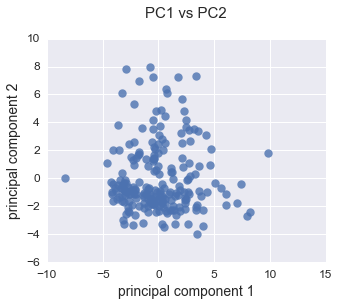

In [112]:
fig = plt.figure(figsize=(5,4))

ax = fig.gca()
ax = sns.regplot(j,k,
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=14)
ax.set_ylabel('principal component 2', fontsize=14)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=15
            )

plt.show()

Okay, that's a little blobbier. Let's see what DB-SCAN can make of it.

In [113]:
db = DBSCAN(eps =1.5, min_samples=3)
db.fit(xStand)

core_samples = db.core_sample_indices_
labels = db.labels_

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Silhouette Coefficient: -0.118


In [114]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

Estimated number of clusters: 2
Silhouette Coefficient: -0.166


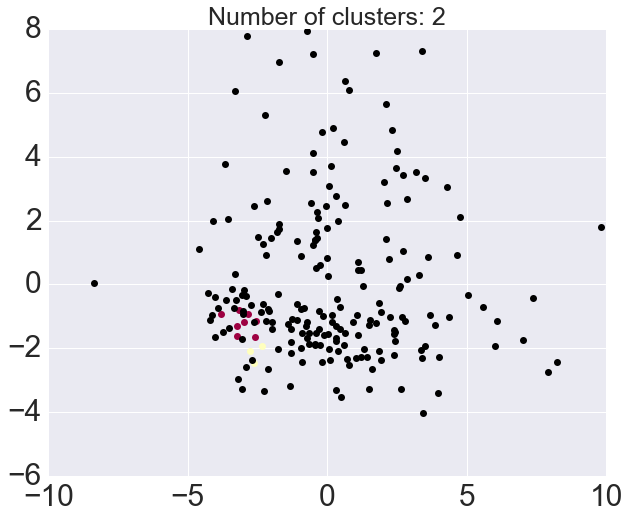

In [115]:
fig = plt.figure(figsize=(10,8))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=7)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=7)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

plt.title('Number of clusters: %d' % n_clusters_, fontsize=25);


so it's mostly noise with a little signal in there somewhere. Maybe we need to look at the data a little differently...in 3D!

In [116]:
xStand = pd.DataFrame(StandardScaler().fit_transform(x2), columns=df1214.columns[2:34])
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

pca3 = PCA(n_components=3)
X3 = pca3.fit_transform(xStand)

covMat = np.cov(X3.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()

totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)

[  41.35543711   75.67349439  100.        ]


In [117]:
PCAdf3 = pd.DataFrame(X3, columns=['PC1','PC2','PC3'])
j = PCAdf3.PC1
k = PCAdf3.PC2
l = PCAdf3.PC3

PCAdf3.head()

,PC1,PC2,PC3
0,-3.063637,-1.720386,0.375925
1,-0.202416,-2.422799,-0.521408
2,2.647424,-3.277333,-1.231126
3,-4.038437,-0.402134,1.259091
4,-3.932380,-0.733440,1.399758


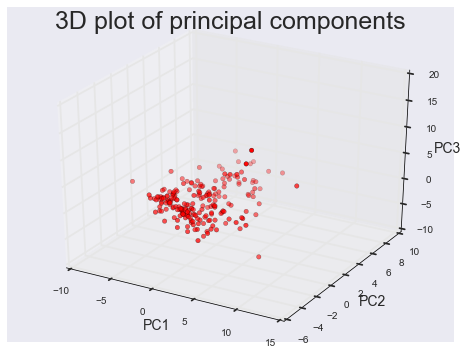

In [118]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = j, ys = k, zs = l, c=('R','G','B'))
ax.set_xlabel('PC1', fontsize=14);
ax.set_ylabel('PC2', fontsize=14);
ax.set_zlabel('PC3', fontsize=14);
ax.set_title("3D plot of principal components", fontsize = 25)

plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11) 


plt.show()
    

I doubt DB-SCAN will do any better with this, but let's give it a try

In [119]:
db = DBSCAN(eps =1.8, min_samples=4)
db.fit(xStand)

core_samples = db.core_sample_indices_
labels = db.labels_

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Silhouette Coefficient: -0.283


In [120]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

Estimated number of clusters: 2
Silhouette Coefficient: -0.244


so that definitely didn't help. Time to get K-Mean about things.

In [121]:
k_list = [2, 3, 4,5,6]

for k in k_list:
    kmean = KMeans(n_clusters=k)
    kmean.fit(x2)
    random_state = 43
    print k, silhouette_score(x2, kmean.labels_), kmean.inertia_
    print

2 0.693676322538 930855570804.0

3 0.676942964096 464953183297.0

4 0.57564216532 293354720239.0

5 0.586572793673 170691899323.0

6 0.593863408615 111047067958.0



Inertia for 2 clusters is so much stronger than for anything further that it's hard to justify using more, but one of the issues I'm trying to address with this is a lack of clusters.

I'll try mapping out 2, 3, and 4 and see what looks best.

In [122]:
chosen_k = 2

kmean = KMeans(n_clusters=chosen_k, random_state=43)
clusters = kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

kmean_df = pd.concat([PCAdf3,label], axis = 1)
kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,1
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


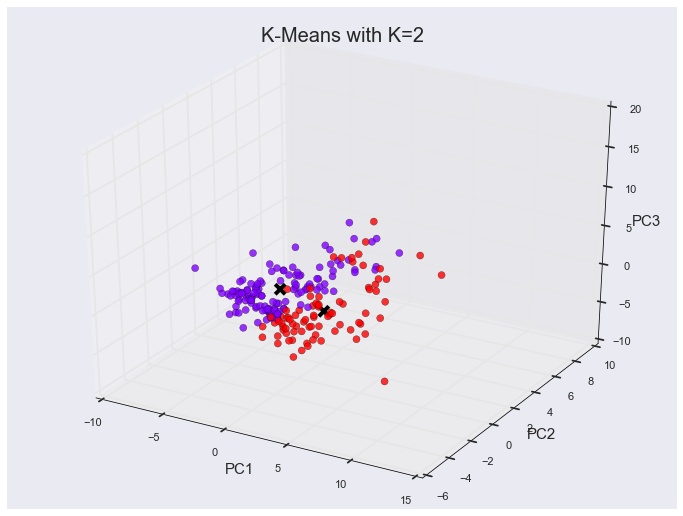

In [123]:
centroid = pd.DataFrame(kmean.cluster_centers_, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')



ax.scatter(xs = centroid['PC1'] , ys = centroid['PC2'], zs = centroid['PC3'], \
           s = 100, c = 'black', marker = 'x', linewidth = 4, alpha = 1.0)
ax.scatter(xs = kmean_df['PC1'] , ys = kmean_df['PC2'], zs=kmean_df['PC3'], alpha = 0.8, \
           s = 50, c = kmean_df['label'], cmap = 'rainbow')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax.set_title('K-Means with K=2', fontsize = 20)

plt.show()



well that looks pretty sweet!

In [266]:
chosen_k = 3

kmean = KMeans(n_clusters=chosen_k, random_state=43)
clusters = kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

centroids = kmean.cluster_centers_

kmean_df = pd.concat([PCAdf3,label], axis = 1)


kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,1
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


In [267]:
kmean_df['label'].value_counts()

0    104
1     66
2     41
Name: label, dtype: int64

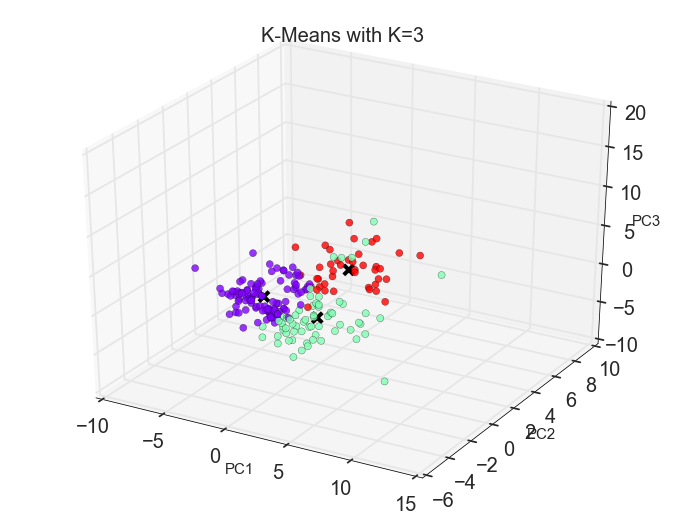

In [268]:
pcakm = pd.DataFrame(centroids, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs = pcakm['PC1'] , ys = pcakm['PC2'], zs = pcakm['PC3'], \
           s = 100, c = 'black', marker = 'x', linewidth = 4, alpha = 1.0)
ax.scatter(xs = kmean_df['PC1'] , ys = kmean_df['PC2'], zs=kmean_df['PC3'], alpha = 0.8, \
           s = 50, c = kmean_df['label'], cmap = 'rainbow')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax.set_title('K-Means with K=3', fontsize = 20)

plt.show()

# plt.savefig('xxxxxxx.png')


even better! let's see 4 and be done for the day'

In [274]:
chosen_k = 4

kmean = KMeans(n_clusters=chosen_k, random_state=43)
kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

kmean_df = pd.concat([PCAdf3,label], axis = 1)
kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,2
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


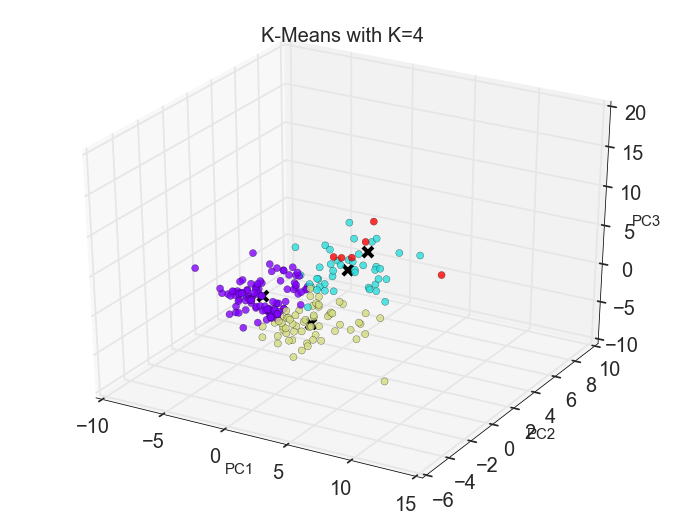

In [275]:
centroid = pd.DataFrame(kmean.cluster_centers_, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs = centroid['PC1'] , ys = centroid['PC2'], zs = centroid['PC3'], \
           s = 100, c = 'black', marker = 'x', linewidth = 4, alpha = 1.0)
ax.scatter(xs = kmean_df['PC1'] , ys = kmean_df['PC2'], zs=kmean_df['PC3'], alpha = 0.8, \
           s = 50, c = kmean_df['label'], cmap = 'rainbow')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax.set_title('K-Means with K=4', fontsize = 20)
plt.show()

Let's go with 3--that fourth one is bleh (technically speaking)

In [276]:
# rerunning the clusters for k=3 for use in the next steps

chosen_k = 3

kmean = KMeans(n_clusters=chosen_k, random_state=43)
clusters = kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

centroids = kmean.cluster_centers_

kmean_df = pd.concat([PCAdf3,label], axis = 1)


kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,1
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


## Okay, now we've got our clusters. 

## The next step is to use them to ID the airports that have the problems

In [277]:
kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,1
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


In [278]:
df1214.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 34 columns):
ap_name                  211 non-null object
year                     211 non-null float64
D_cancel                 211 non-null float64
A_cancel                 211 non-null float64
D_divert                 211 non-null float64
A_divert                 211 non-null float64
D_4met                   211 non-null int64
A_4met                   211 non-null int64
%on/t_gate_D             211 non-null float64
%on/t_ap_D               211 non-null float64
%on/t_gate_A             211 non-null float64
avg_taxi_out_time        211 non-null float64
avg_taxi_out_del         211 non-null float64
avg_ap_D_del             211 non-null float64
avg_airborne_del         211 non-null float64
avg_taxi_in_del          211 non-null float64
avg_block_del            211 non-null float64
avg_gate_A_del           211 non-null float64
Chg_D_cancel             211 non-null float64
Chg_A_cancel             2

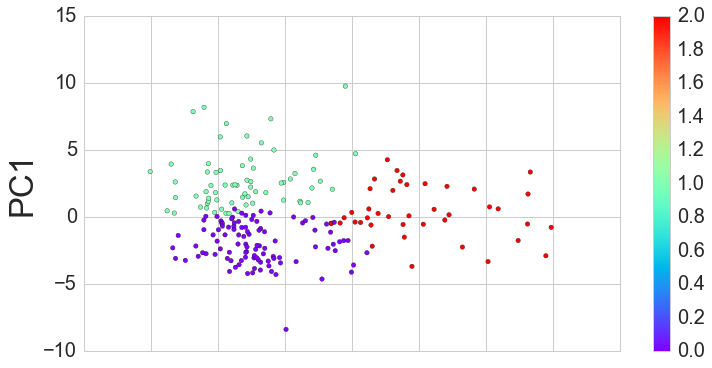

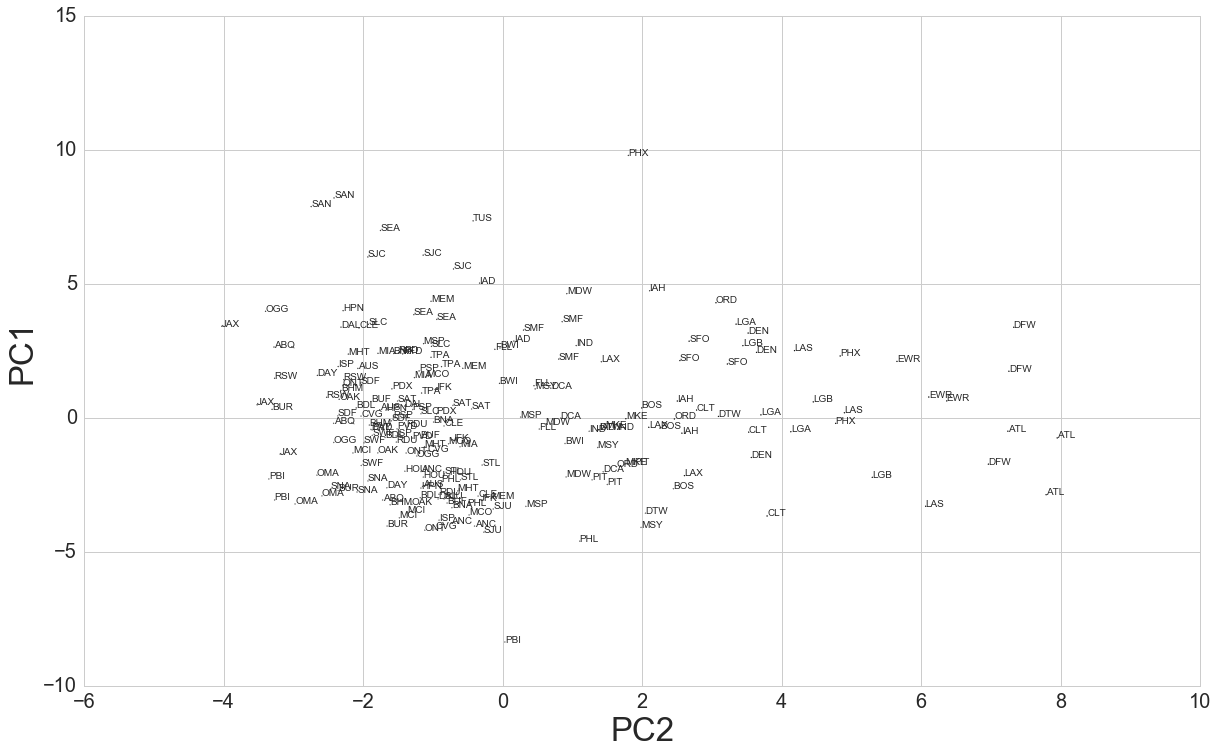

In [279]:
graph = kmean_df.plot(
    kind = "scatter",
    x = 'PC2', y='PC1',
    c = kmean_df.label.astype(np.float),
    cmap = 'rainbow',
    figsize = (12,6))


graph2 = kmean_df.plot(
    kind = "scatter",
    x = 'PC2', y='PC1',
    c = kmean_df.label.astype(np.float),
      s = 1,
    figsize = (20,12))

for i, airport in enumerate (df1214['ap_name']):
    graph2.annotate(airport, (kmean_df.iloc[i].PC2, kmean_df.iloc[i].PC1), size=10)



Block Delay is the gate-to-gate delay, so the biggest problem. Let's see what airports have the biggest and least problems with this metric.


In [272]:
kml = pd.DataFrame(kmean.labels_)

In [273]:
kml.sort()

/Users/EKandTower/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(....) is deprecated, use sort_index(.....)



,0
0,0
1,0
2,1
3,0
4,0
5,0
6,2
7,2
8,2
9,0


In [142]:
df1214.head(50)

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
8,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,...,0.026733,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461
9,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,...,-0.048501,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498
10,ABQ,2014.0,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,...,-0.106702,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918
19,ANC,2012.0,216.0,284.0,78.0,36.0,70322,66453,0.8442,0.8235,...,0.077060,0.104332,0.184130,-0.112206,-0.336245,-0.372146,-0.247563,-0.128205,-0.361158,-0.484245
20,ANC,2013.0,141.0,184.0,65.0,40.0,69984,65469,0.8432,0.8228,...,0.057702,0.068849,0.139707,-0.104911,-0.188172,-0.314538,-0.337232,-0.253968,-0.355818,-0.467590
21,ANC,2014.0,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,...,0.021696,0.015342,0.040658,-0.092874,-0.141935,-0.222922,0.062338,0.741935,0.090692,-0.321630
30,ATL,2012.0,2259.0,2782.0,798.0,655.0,457501,455968,0.8320,0.7401,...,0.160876,0.295466,0.131077,-0.044230,-0.271739,-0.402812,-0.582474,-0.249400,-0.347630,-0.361715
31,ATL,2013.0,2916.0,3450.0,870.0,655.0,448180,445498,0.7917,0.7025,...,0.028716,0.157141,0.067602,-0.116505,-0.352941,-0.213525,-0.420925,-0.361179,-0.284872,-0.189052
32,ATL,2014.0,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,...,0.015949,0.209153,0.107430,-0.203297,-0.494347,-0.258380,-0.172205,-0.416842,-0.436842,-0.249093
41,AUS,2012.0,353.0,323.0,80.0,60.0,56043,55752,0.8083,0.7840,...,0.037746,0.045473,0.072918,-0.042149,-0.178832,-0.157539,-0.298755,-0.070866,-0.286957,-0.200780


In [154]:
df1214.reset_index(drop=True, inplace=True)
kml.reset_index(drop=True, inplace=True)

dfc = pd.concat([df1214,kml], axis = 1)


In [155]:
dfc.head()

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del,0
0,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,...,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461,0
1,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,...,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498,0
2,ABQ,2014.0,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,...,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918,2
3,ANC,2012.0,216.0,284.0,78.0,36.0,70322,66453,0.8442,0.8235,...,0.104332,0.184130,-0.112206,-0.336245,-0.372146,-0.247563,-0.128205,-0.361158,-0.484245,0
4,ANC,2013.0,141.0,184.0,65.0,40.0,69984,65469,0.8432,0.8228,...,0.068849,0.139707,-0.104911,-0.188172,-0.314538,-0.337232,-0.253968,-0.355818,-0.467590,0


In [157]:
dfc.rename(columns={0:'cluster'}, inplace=True)
dfc.head()

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del,cluster
0,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,...,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461,0
1,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,...,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498,0
2,ABQ,2014.0,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,...,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918,2
3,ANC,2012.0,216.0,284.0,78.0,36.0,70322,66453,0.8442,0.8235,...,0.104332,0.184130,-0.112206,-0.336245,-0.372146,-0.247563,-0.128205,-0.361158,-0.484245,0
4,ANC,2013.0,141.0,184.0,65.0,40.0,69984,65469,0.8432,0.8228,...,0.068849,0.139707,-0.104911,-0.188172,-0.314538,-0.337232,-0.253968,-0.355818,-0.467590,0


In [162]:
df14c = pd.DataFrame(dfc)
df14c = pd.DataFrame(df14c.loc[df14c['year'] == 2014])

# df14c.replace([np.inf, -np.inf], np.nan, inplace=True)
# df14.dropna(inplace=True)
df14c.drop(['year'], axis=1, inplace=True)

df14c.head()

,ap_name,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,...,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del,cluster
2,ABQ,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,0.7320,...,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918,2
5,ANC,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,0.8600,...,0.015342,0.040658,-0.092874,-0.141935,-0.222922,0.062338,0.741935,0.090692,-0.321630,0
8,ATL,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,0.8123,...,0.209153,0.107430,-0.203297,-0.494347,-0.258380,-0.172205,-0.416842,-0.436842,-0.249093,1
11,AUS,484.0,435.0,88.0,97.0,60588,60264,0.7627,0.7382,0.7222,...,-0.070628,-0.064508,0.007712,0.004878,0.274734,-0.004425,-0.068966,0.070632,0.272584,2
14,BDL,467.0,421.0,57.0,32.0,39279,39109,0.7953,0.7605,0.7569,...,-0.042674,-0.045884,-0.019969,-0.107266,0.167072,-0.212121,0.104651,-0.098976,0.264103,2


In [164]:
dfc_list = ['ap_name','cluster','avg_block_del', 'Chg_avg_block_del']
dfc2 = df14c[dfc_list]

dfc2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 2 to 209
Data columns (total 4 columns):
ap_name              69 non-null object
cluster              69 non-null int32
avg_block_del        69 non-null float64
Chg_avg_block_del    69 non-null float64
dtypes: float64(2), int32(1), object(1)
memory usage: 2.4+ KB


In [219]:
dfc2.head()

,ap_name,cluster,avg_block_del,Chg_avg_block_del
182,SEA,2,5.13,0.806338
188,SJC,2,4.72,0.216495
74,IAD,2,4.60,0.108434
5,ANC,0,4.57,0.090692
56,DFW,1,4.44,0.190349


In [260]:
gb = dfc2.groupby(['cluster'])[['avg_block_del', 'Chg_avg_block_del']].mean()

In [262]:
gbdf = pd.DataFrame(gb)
gbdf.head()

,avg_block_del,Chg_avg_block_del
cluster,,
0,2.855882,-0.064157
1,3.493077,-0.072520
2,3.161053,0.105313
3,3.330000,0.136519


In [207]:
airports = pd.Series(dfc2.ap_name)
avg_block_delays = pd.Series(dfc2.avg_block_del)
change_block_delays = pd.Series(dfc2.Chg_avg_block_del)

In [181]:
abd_list = ['ap_name','avg_block_del']
chg_list = ['ap_name','Chg_avg_block_del']
dfc2_abd = pd.DataFrame(dfc2[abd_list])
dfc2_chg = pd.DataFrame(dfc2[chg_list])

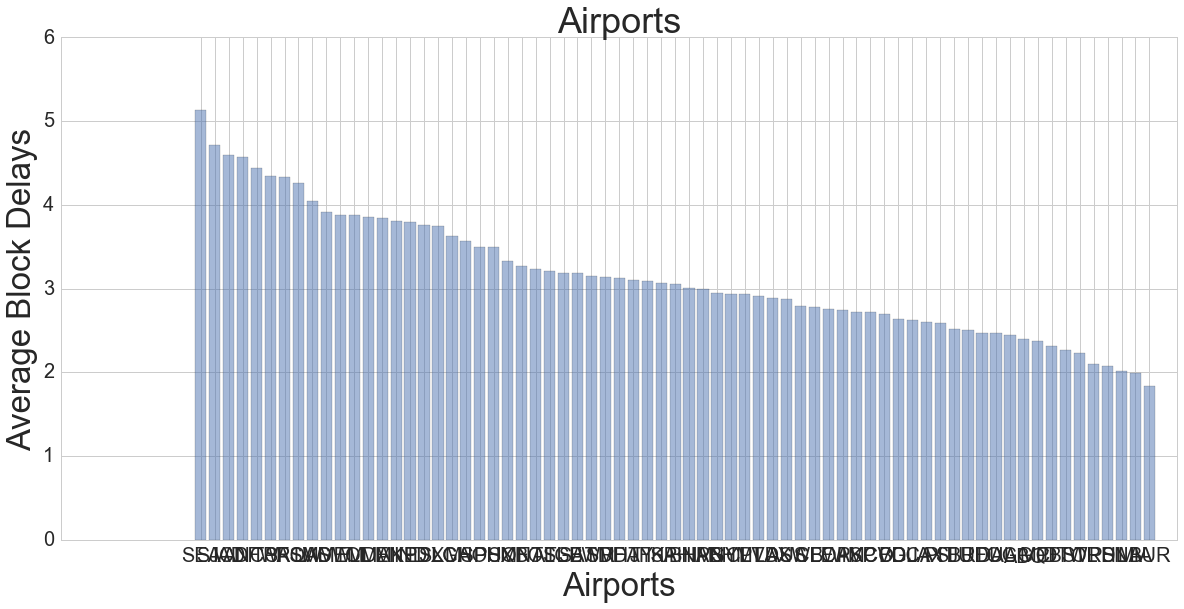

In [247]:
fig = plt.figure(figsize = (20,9))

objects = (airports)
y_pos = np.arange(len(airports))
performance = (avg_block_delays)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Airports')
plt.ylabel('Average Block Delays')
# plt.title('Airports')
    
    
plt.show()

In [ ]:
n_groups = 5
means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)
means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.barh(index, means_men, bar_width,
alpha=opacity,
color='b',
yerr=std_men,
error_kw=error_config,
label='Men')


plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
plt.legend()
plt.tight_layout()
plt.show()

In [172]:
dfc2.sort_values(by='avg_block_del', inplace=True)
dfc2.head(15)

/Users/EKandTower/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,ap_name,cluster,avg_block_del,Chg_avg_block_del
29,BUR,2,1.84,0.063584
119,MIA,2,1.99,-0.200803
200,SNA,0,2.01,-0.186235
151,PHL,0,2.08,-0.280277
143,ORD,1,2.10,0.578947
203,STL,0,2.23,-0.346041
59,DTW,0,2.27,-0.305810
146,PBI,0,2.31,0.094787
104,MCI,0,2.37,-0.290419
2,ABQ,2,2.40,0.212121


The quintile (14 airports) with the lowest block delay times are:
* BUR
* MIA
* SNA
* PHL
* ORD
* STL
* DTW
* PBI
* MCI
* ABQ
* OGG
* DAL
* RDU
* BUF


of these, 6 were from cluster 2, 1 was from cluster 1, and 7 were from cluster 0


In [174]:
dfc2.sort_values(by='avg_block_del', inplace=True, ascending=False)
dfc2.head(15)

/Users/EKandTower/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,ap_name,cluster,avg_block_del,Chg_avg_block_del
182,SEA,2,5.13,0.806338
188,SJC,2,4.72,0.216495
74,IAD,2,4.60,0.108434
5,ANC,0,4.57,0.090692
56,DFW,1,4.44,0.190349
209,TPA,2,4.34,-0.241259
185,SFO,1,4.33,0.196133
171,RSW,2,4.26,0.521429
92,LAS,1,4.05,-0.196429
110,MDW,2,3.91,0.150000


The quintile (14 airports) with the highest block delay times are:
* SEA
* SJC
* IAD
* ANC
* DFW
* TPA
* SFO
* RSW
* LAS
* MDW
* MEM
* FLL
* OMA
* DEN

of these, 8 were from cluster 2, 4 were from cluster 1, and 2 were from cluster 0